<a href="https://colab.research.google.com/github/NehalNN10/Deep_Learning_Project_Fall_25/blob/main/PredRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:


data = np.load('/content/drive/MyDrive/EarthEngineExports/DW_data.npy')  # shape (476, 69, 88, 9)

T = 12  # number of past frames
X, y = [], []

for i in range(len(data) - T):
    X.append(data[i:i+T])     # 12 past frames
    y.append(data[i+T])       # next frame

X = np.array(X)  # (N, T, H, W, 9)
y = np.array(y)  # (N, H, W, 9)

# Optional: normalize (already 0–1), maybe smooth temporal noise

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
print(np.shape(X_train)[0])
print(np.shape(X_val)[0])

371
93


In [ ]:
X_train = np.moveaxis(X_train, -1, 2)  # (N, T, 9, H, W)
y_train = np.moveaxis(y_train, -1, 1)  # (N, 9, H, W)
X_val = np.moveaxis(X_val, -1, 2)    # Apply the same for validation set
y_val = np.moveaxis(y_val, -1, 1)    # Apply the same for validation set

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## SpatioTemporal ConvLSTM

In [ ]:
class SpatioTemporalLSTMCell(nn.Module):
    def __init__(self, in_channel, num_hidden, height, width, filter_size, stride, layer_norm=True):
        super().__init__()
        padding = filter_size // 2
        self.num_hidden = num_hidden
        self.layer_norm = layer_norm

        self.conv_x = nn.Conv2d(in_channel, num_hidden * 7, filter_size, stride, padding)
        self.conv_h = nn.Conv2d(num_hidden, num_hidden * 4, filter_size, stride, padding)
        self.conv_m = nn.Conv2d(num_hidden, num_hidden * 3, filter_size, stride, padding)
        self.conv_o = nn.Conv2d(num_hidden * 2, num_hidden, filter_size, stride, padding)
        self.conv_last = nn.Conv2d(num_hidden, num_hidden, 1, 1, 0)

        if layer_norm:
            self.norm_x = nn.LayerNorm([num_hidden * 7, height, width])
            self.norm_h = nn.LayerNorm([num_hidden * 4, height, width])
            self.norm_m = nn.LayerNorm([num_hidden * 3, height, width])
            self.norm_c = nn.LayerNorm([num_hidden, height, width])
            self.norm_mem = nn.LayerNorm([num_hidden, height, width])

    def forward(self, x_t, h_t, c_t, m_t):
        x_concat = self.conv_x(x_t)
        h_concat = self.conv_h(h_t)
        m_concat = self.conv_m(m_t)

        if self.layer_norm:
            x_concat = self.norm_x(x_concat)
            h_concat = self.norm_h(h_concat)
            m_concat = self.norm_m(m_concat)

        i_x, f_x, g_x, o_x, i_m_x, f_m_x, g_m_x = torch.split(x_concat, self.num_hidden, dim=1)
        i_h, f_h, g_h, o_h = torch.split(h_concat, self.num_hidden, dim=1)
        i_m, f_m, g_m = torch.split(m_concat, self.num_hidden, dim=1)

        i_t = torch.sigmoid(i_x + i_h)
        f_t = torch.sigmoid(f_x + f_h + self.conv_last(m_t))
        g_t = torch.tanh(g_x + g_h)

        c_new = f_t * c_t + i_t * g_t

        if self.layer_norm:
            c_new = self.norm_c(c_new)

        i_m_t = torch.sigmoid(i_m_x + i_m)
        f_m_t = torch.sigmoid(f_m_x + f_m)
        g_m_t = torch.tanh(g_m_x + g_m)

        m_new = f_m_t * m_t + i_m_t * g_m_t

        if self.layer_norm:
            m_new = self.norm_mem(m_new)

        o_t = torch.sigmoid(o_x + o_h + self.conv_last(m_new))
        h_new = o_t * torch.tanh(c_new + self.conv_last(m_new))

        return h_new, c_new, m_new

In [ ]:
class PredRNN(nn.Module):
    def __init__(self, num_layers, num_hidden, in_channel, height, width, filter_size):
        super().__init__()
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.height = height
        self.width = width
        self.filter_size = filter_size

        self.frame_channel = in_channel
        cell_list = []
        for i in range(num_layers):
            in_channel_layer = self.frame_channel if i == 0 else num_hidden[i-1]
            cell_list.append(
                SpatioTemporalLSTMCell(in_channel_layer, num_hidden[i], height, width, filter_size, 1)
            )
        self.cell_list = nn.ModuleList(cell_list)
        self.conv_last = nn.Conv2d(num_hidden[-1], self.frame_channel, 1, 1, 0)

    def forward(self, frames, pred_len):
        # frames: [B, T_in, C, H, W]
        B, T_in, C, H, W = frames.shape
        h_t, c_t, m_t = [], [], None
        for i in range(self.num_layers):
            h_t.append(torch.zeros(B, self.num_hidden[i], H, W, device=frames.device))
            c_t.append(torch.zeros_like(h_t[i]))
        m_t = torch.zeros_like(h_t[0])

        outputs = []
        for t in range(T_in + pred_len):
            if t < T_in:
                x = frames[:, t]
            else:
                x = x_gen
            for i, cell in enumerate(self.cell_list):
                h_t[i], c_t[i], m_t = cell(x, h_t[i], c_t[i], m_t)
                x = h_t[i]
            x_gen = self.conv_last(x)
            if t >= T_in:
                outputs.append(x_gen)
        return torch.stack(outputs, dim=1)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import TensorDataset

# Convert numpy arrays to torch tensors and create a TensorDataset
# Ensure X_train and y_train are float32
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Re-initialize test_dataset and test_loader with the correctly preprocessed X_val and y_val
test_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

### Training

In [ ]:
# X_train has shape (N, T, C, H, W) after moveaxis
input_H = X_train.shape[3]
input_W = X_train.shape[4]

model = PredRNN(
    num_layers=2,
    num_hidden=[64, 64],
    in_channel=9,     # DW has 9 bands
    height=input_H,
    width=input_W,
    filter_size=3
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    # Use the correctly defined train_loader
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        # PredRNN expects input frames as (B, T_in, C, H, W)
        # It predicts `pred_len` frames.
        # y_train is (N, C, H, W), representing a single next frame.
        # So, pred_len should be 1.
        pred_len = 4
        pred = model(x, pred_len=pred_len)

        # The model output 'pred' for pred_len=1 will be (B, 1, C, H, W).
        # The target 'y' is (B, C, H, W).
        # We need to make their shapes compatible for MSELoss.
        # Unsqueeze 'y' to (B, 1, C, H, W) to match 'pred'.
        y = y.unsqueeze(1)

        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.6f}")

### Saving Model Weights

In [ ]:
import os

# Define the path to save the model
model_save_path = '/content/drive/MyDrive/predrnn_model.pth'

torch.save(model.state_dict(), model_save_path)

print(f"Model weights saved to {model_save_path}")

# You can also save to Google Drive if it's mounted
# drive_save_path = '/content/drive/MyDrive/predrnn_model.pth'
# torch.save(model.state_dict(), drive_save_path)
# print(f"Model weights also saved to Google Drive at {drive_save_path}")

Model weights saved to /content/drive/MyDrive/predrnn_model.pth


In [ ]:
model.eval()
with torch.no_grad(): # Disable gradient calculations for inference
    x, y = next(iter(test_loader))
    x, y = x.to(device), y.to(device)

    # pred_len should be 1 as the model was trained to predict the single next frame
    pred_len = 1
    pred = model(x, pred_len=pred_len).detach().cpu() # pred will be (B, 1, C, H, W)

# Assuming we want to visualize the first channel (index 0) of the first item in the batch
# pred is (B, pred_len, C, H, W). For pred_len=1, it's (B, 1, C, H, W). We want pred[0, 0, 0]
# y is (B, C, H, W). We want y[0, 0]

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(pred[0, 0, 0], cmap='viridis')
plt.title('Predicted (First Channel)')

plt.subplot(1,2,2)
plt.imshow(y[0, 0].cpu(), cmap='viridis')
plt.title('Ground Truth (First Channel)')
plt.show()

NameError: name 'loaded_model' is not defined

# Load the Saved PredRNN Model

### Subtask:
Instantiate the `PredRNN` model with the correct architecture and load the pre-trained weights from the specified path.


In [ ]:
model_save_path = '/content/drive/MyDrive/DL Trained Models/predrnn_model_1frame.pth'

# Instantiate the PredRNN model with the correct architecture
# These parameters should match how the model was defined in cell bRydQyBxLzyr
loaded_model = PredRNN(
    num_layers=2,
    num_hidden=[64, 64],
    in_channel=9,
    height=X_train.shape[3],
    width=X_train.shape[4],
    filter_size=3
).to(device)

# Load the saved state dictionary (this should load the weights from the 10-epoch training)
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
loaded_model.eval()

print("Trained PredRNN model instantiated and weights loaded successfully.")


Trained PredRNN model instantiated and weights loaded successfully.


In [ ]:
loaded_model.eval()
with torch.no_grad():
    # Get one batch of test data
    x_val, y_val = next(iter(test_loader))
    x_val, y_val = x_val.to(device), y_val.to(device)

    # Make a prediction for a single future frame
    pred_len = 1
    val_pred = loaded_model(x_val, pred_len=pred_len)

    # Take the first sample from the batch
    # y_val_sample shape: (C, H, W)
    # val_pred_sample shape: (C, H, W) (after squeezing the pred_len dimension)
    y_val_sample = y_val[0].cpu().numpy()
    val_pred_sample = val_pred[0, 0].cpu().numpy()

# Calculate mean values for each band across spatial dimensions
actual_band_means = np.mean(y_val_sample, axis=(1, 2))
predicted_band_means = np.mean(val_pred_sample, axis=(1, 2))

print("Numerical Comparison of Actual vs. Predicted Band Means (First Sample in Batch):")
print("------------------------------------------------------------------")
for i in range(9):
    print(f"Band {i+1}: Actual = {actual_band_means[i]:.6f}, Predicted = {predicted_band_means[i]:.6f}")
print("------------------------------------------------------------------")


Numerical Comparison of Actual vs. Predicted Band Means (First Sample in Batch):
------------------------------------------------------------------
Band 1: Actual = 0.181146, Predicted = 0.191655
Band 2: Actual = 0.090781, Predicted = 0.094678
Band 3: Actual = 0.250252, Predicted = 0.241428
Band 4: Actual = 0.038978, Predicted = 0.038005
Band 5: Actual = 0.055639, Predicted = 0.049291
Band 6: Actual = 0.158970, Predicted = 0.145958
Band 7: Actual = 0.043167, Predicted = 0.047332
Band 8: Actual = 0.088588, Predicted = 0.086552
Band 9: Actual = 0.060233, Predicted = 0.058927
------------------------------------------------------------------


## Evaluate the Loaded Model and Calculate Metrics

Evaluate the loaded PredRNN model on the test data and calculate average MSE, MAE, SSIM, and overall pixel-wise correlation.


### Define Evaluation Metrics

### Subtask:
Introduce the Structural Similarity Index (SSIM) as an additional evaluation metric for a more perceptual quality assessment of the predicted frames.


In [ ]:
from skimage.metrics import structural_similarity
import numpy as np

def calculate_ssim(img1, img2):
    """
    Calculates the Structural Similarity Index (SSIM) between two images,
    averaging the scores across all channels.

    Args:
        img1 (np.ndarray): The first image array (predicted frame).
                           Expected shape (C, H, W).
        img2 (np.ndarray): The second image array (ground truth frame).
                           Expected shape (C, H, W).

    Returns:
        float: The average SSIM score across all channels.
    """
    ssim_scores = []
    num_channels = img1.shape[0]

    for i in range(num_channels):
        # structural_similarity expects 2D arrays (H, W) for single channel.
        # We feed one channel at a time.
        score = structural_similarity(img1[i], img2[i], data_range=1.0)
        ssim_scores.append(score)

    return np.mean(ssim_scores)

print("SSIM metric definition complete.")

SSIM metric definition complete.


**Reasoning**:
I will evaluate the `loaded_model` on the test data by iterating through the `test_loader`, making predictions, and calculating MSE, MAE, SSIM, and overall pixel-wise correlation as instructed. This involves using the previously defined `calculate_ssim` function and standard `sklearn.metrics` for error calculations.



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from tqdm import tqdm

# Ensure the model is in evaluation mode
loaded_model.eval()

# Initialize lists to store metrics
val_mses = []
val_maes = []
val_ssims = []
all_preds = [] # List to store all predictions for correlation
all_trues = [] # List to store all ground truths for correlation

with torch.no_grad(): # Disable gradient calculations for inference
    for x_val, y_val in tqdm(test_loader, desc="Evaluating Loaded Model"):
        x_val, y_val = x_val.to(device), y_val.to(device)

        pred_len = 1 # Predict a single next frame
        val_pred = loaded_model(x_val, pred_len=pred_len)

        # Reshape for metric calculation
        # val_pred shape: (B, 1, C, H, W)
        # y_val shape: (B, C, H, W)

        # --- Calculate MSE and MAE ---
        val_pred_flat = val_pred.squeeze(1).cpu().numpy().flatten() # Remove pred_len dim and flatten
        y_val_flat = y_val.cpu().numpy().flatten()

        val_mses.append(mean_squared_error(y_val_flat, val_pred_flat))
        val_maes.append(mean_absolute_error(y_val_flat, val_pred_flat))

        # --- Calculate SSIM per batch item ---
        for i in range(x_val.size(0)): # Iterate through each item in the batch
            val_pred_item = val_pred[i, 0].cpu().numpy() # (C, H, W)
            y_val_item = y_val[i].cpu().numpy() # (C, H, W)
            val_ssims.append(calculate_ssim(val_pred_item, y_val_item))

        # Store predictions and ground truths for overall correlation
        all_preds.append(val_pred.squeeze(1).cpu().numpy()) # (B, C, H, W)
        all_trues.append(y_val.cpu().numpy()) # (B, C, H, W)

# --- Aggregate and print results ---
print(f"\nAverage Validation MSE: {np.mean(val_mses):.6f}")
print(f"Average Validation MAE: {np.mean(val_maes):.6f}")
print(f"Average Validation SSIM: {np.mean(val_ssims):.6f}")

# --- Overall Correlation Calculation ---
preds_concat = np.concatenate(all_preds, axis=0)
trues_concat = np.concatenate(all_trues, axis=0)

preds_flat_overall = preds_concat.flatten()
trues_flat_overall = trues_concat.flatten()

overall_corr = np.corrcoef(preds_flat_overall, trues_flat_overall)[0, 1]
print(f"Overall Pixel-wise Correlation: {overall_corr:.4f}")

Evaluating Loaded Model: 100%|██████████| 47/47 [05:47<00:00,  7.39s/it]



Average Validation MSE: 0.001011
Average Validation MAE: 0.016973
Average Validation SSIM: 0.895633
Overall Pixel-wise Correlation: 0.9595


### Visualization

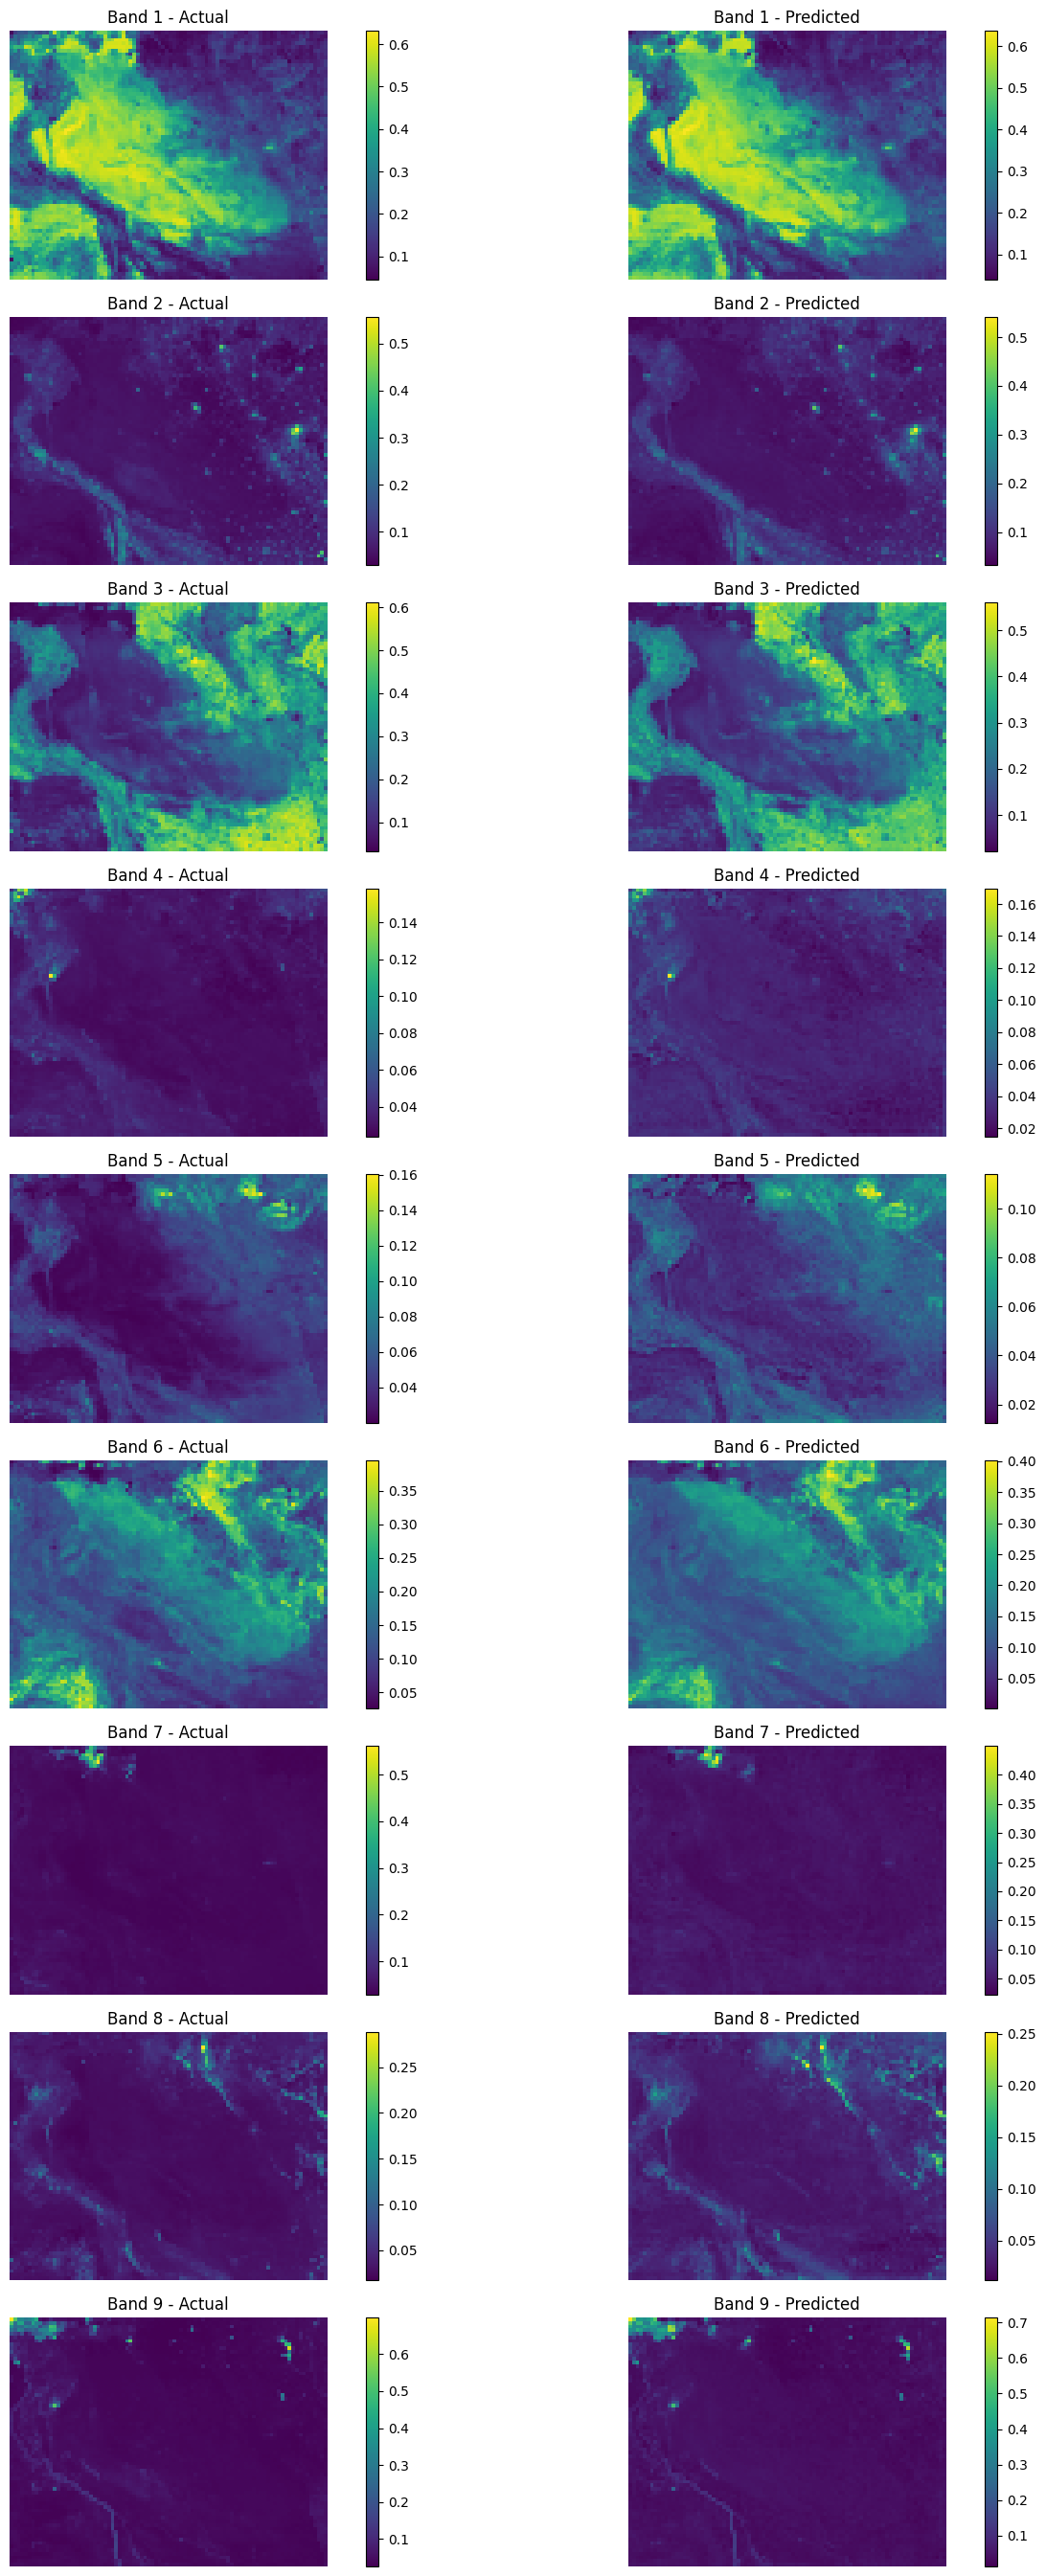

Visual comparison of actual vs. predicted maps for all 9 bands.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
loaded_model.eval()

with torch.no_grad():
    # Get one batch of test data
    x_val, y_val = next(iter(test_loader))
    x_val, y_val = x_val.to(device), y_val.to(device)

    # Make a prediction for a single future frame (pred_len=1 as trained)
    pred_len = 1
    val_pred = loaded_model(x_val, pred_len=pred_len)

    # Take the first sample from the batch and convert to numpy
    # y_val_sample shape: (C, H, W)
    # val_pred_sample shape: (C, H, W) (after squeezing the pred_len dimension)
    y_val_sample = y_val[0].cpu().numpy()
    val_pred_sample = val_pred[0, 0].cpu().numpy()

# Visualize each of the 9 bands
num_bands = y_val_sample.shape[0] # Should be 9

plt.figure(figsize=(15, 3 * num_bands)) # Adjust figure size for better visibility

for i in range(num_bands):
    # Subplot for Actual Band
    plt.subplot(num_bands, 2, 2 * i + 1)
    plt.imshow(y_val_sample[i], cmap='viridis')
    plt.title(f'Band {i+1} - Actual')
    plt.colorbar()
    plt.axis('off')

    # Subplot for Predicted Band
    plt.subplot(num_bands, 2, 2 * i + 2)
    plt.imshow(val_pred_sample[i], cmap='viridis')
    plt.title(f'Band {i+1} - Predicted')
    plt.colorbar()
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Visual comparison of actual vs. predicted maps for all 9 bands.")


# GAN

## Prepare `data` for `DWSequenceDataset`

### Subtask:
Rearrange the dimensions of the `data` array from `[Total_frames, Height, Width, Channels]` to `[Total_frames, Channels, Height, Width]` using `np.moveaxis`.


In [ ]:
class DWSequenceDataset(Dataset):
    def __init__(self, data, T_in=8, T_out=4):
        self.data = data  # numpy array [T, C, H, W]
        self.T_in = T_in
        self.T_out = T_out

    def __len__(self):
        return len(self.data) - (self.T_in + self.T_out)

    def __getitem__(self, idx):
        seq = self.data[idx : idx + self.T_in + self.T_out]
        x = seq[:self.T_in]
        y = seq[self.T_in:]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


**Reasoning**:
To prepare the `data` array for the `DWSequenceDataset` as specified, I need to rearrange its dimensions from `[Total_frames, Height, Width, Channels]` to `[Total_frames, Channels, Height, Width]` using `np.moveaxis`. The Channels dimension is at index -1 and should be moved to index 1.



In [ ]:
data_gan = np.moveaxis(data, -1, 1)
print(f"Original data shape: {data.shape}")
print(f"Reshaped data_gan shape: {data_gan.shape}")

Original data shape: (476, 69, 88, 9)
Reshaped data_gan shape: (476, 9, 69, 88)


**Reasoning**:
The next step is to create a new DataLoader for GAN training. This involves instantiating the `DWSequenceDataset` with the reshaped `data_gan` and then creating a `DataLoader` from this dataset. This will provide sequential data with appropriate `T_in` and `T_out` for the GAN model.



In [ ]:
T_in, T_out = 8, 4
gan_dataset = DWSequenceDataset(data_gan, T_in=T_in, T_out=T_out)
gan_loader = DataLoader(gan_dataset, batch_size=2, shuffle=True)

print(f"GAN dataset length: {len(gan_dataset)}")
for x_seq, y_seq in gan_loader:
    print(f"Shape of input sequence (x_seq): {x_seq.shape}") # Should be [B, T_in, C, H, W]
    print(f"Shape of target sequence (y_seq): {y_seq.shape}") # Should be [B, T_out, C, H, W]
    break

GAN dataset length: 464
Shape of input sequence (x_seq): torch.Size([2, 8, 9, 69, 88])
Shape of target sequence (y_seq): torch.Size([2, 4, 9, 69, 88])


**Reasoning**:
The next step is to update the GAN training loop to use the newly created `gan_loader` and also correct the `generator_loss` function call by removing the extra argument. This will resolve the shape mismatch and incorrect argument passing that led to the `RuntimeError`.



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Example config
gen_cfg = dict(
    num_layers=3,
    num_hidden=[64, 64, 64],
    in_channel=9,
    height=69,
    width=88,
    filter_size=5,
)

model = PredRNN_GAN(gen_cfg).to(device)
opt_G = torch.optim.Adam(model.G.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(model.D.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Suppose data_np = your numpy array [T, C, H, W]
# dataset = DWSequenceDataset(data_np)
# loader = DataLoader(dataset, batch_size=4, shuffle=True)

epochs = 50
T_in, T_out = 8, 4

for epoch in range(epochs):
    for x, y in gan_loader: # Use gan_loader instead of train_loader
        x, y = x.to(device), y.to(device)  # [B, T_in, C, H, W], [B, T_out, C, H, W]
        B = x.size(0)

        # ------------------ Train Generator ------------------
        pred_y = model.G(x, pred_len=T_out)  # [B, T_out, C, H, W]
        D_input_fake = torch.cat([x[:, -T_out:], pred_y], dim=1).permute(0,2,1,3,4) # For discriminator, we need a sequence of T_out + T_out frames, which means the last T_out frames of x and the predicted T_out frames.
        pred_logits = model.D(D_input_fake)

        loss_G = generator_loss(pred_y, y, pred_logits) # Removed the extra 'y' argument
        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # ------------------ Train Discriminator ------------------
        with torch.no_grad():
            pred_y = model.G(x, pred_len=T_out)

        D_input_real = torch.cat([x[:, -T_out:], y], dim=1).permute(0,2,1,3,4)
        D_input_fake = torch.cat([x[:, -T_out:], pred_y.detach()], dim=1).permute(0,2,1,3,4)

        real_logits = model.D(D_input_real)
        fake_logits = model.D(D_input_fake)

        loss_D = discriminator_loss(real_logits, fake_logits)
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

    print(f"Epoch {epoch+1}/{epochs} | G_loss: {loss_G.item():.4f} | D_loss: {loss_D.item():.4f}")

Epoch 1/50 | G_loss: 0.0357 | D_loss: 0.4553
Epoch 2/50 | G_loss: 0.0242 | D_loss: 0.3884
Epoch 3/50 | G_loss: 0.0252 | D_loss: 0.7579
Epoch 4/50 | G_loss: 0.0228 | D_loss: 0.7661
Epoch 5/50 | G_loss: 0.0182 | D_loss: 0.5016
Epoch 6/50 | G_loss: 0.0269 | D_loss: 0.3985
Epoch 7/50 | G_loss: 0.0224 | D_loss: 0.1658
Epoch 8/50 | G_loss: 0.0217 | D_loss: 0.3513
Epoch 9/50 | G_loss: 0.0151 | D_loss: 0.5086
Epoch 10/50 | G_loss: 0.0177 | D_loss: 0.4287
Epoch 11/50 | G_loss: 0.0151 | D_loss: 0.7696
Epoch 12/50 | G_loss: 0.0220 | D_loss: 0.3019
Epoch 13/50 | G_loss: 0.0222 | D_loss: 0.2451
Epoch 14/50 | G_loss: 0.0199 | D_loss: 0.4998
Epoch 15/50 | G_loss: 0.0184 | D_loss: 0.4424
Epoch 16/50 | G_loss: 0.0239 | D_loss: 0.4250


**Reasoning**:
I will instantiate the PredRNN model with the specified architecture, move it to the correct device, load the pre-trained weights from the provided path, and then set the model to evaluation mode.



In [ ]:
class PredRNN_GAN(nn.Module):
    def __init__(self, gen_cfg):
        super().__init__()
        self.G = PredRNN(**gen_cfg)
        self.D = Conv3dDiscriminator(in_channels=gen_cfg["in_channel"])

    def forward(self, x, pred_len):
        return self.G(x, pred_len)


In [ ]:
class Conv3dDiscriminator(nn.Module):
    def __init__(self, in_channels=9, base_channels=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv3d(in_channels, base_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(base_channels, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(base_channels*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(base_channels*2, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(base_channels*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(base_channels*4, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        # x: [B, C, T, H, W]
        return self.model(x).mean(dim=[2,3,4])  # [B, 1]


In [ ]:
def generator_loss(pred_seq, real_seq, pred_seq_adv, lambda_adv=0.001, lambda_temp=0.1):
    # Reconstruction loss
    l1_loss = F.l1_loss(pred_seq, real_seq)

    # Adversarial loss (want discriminator to think fake = real)
    adv_loss = F.binary_cross_entropy_with_logits(pred_seq_adv, torch.ones_like(pred_seq_adv))

    # Temporal consistency loss
    temporal_loss = F.mse_loss(pred_seq[:,1:] - pred_seq[:,:-1], real_seq[:,1:] - real_seq[:,:-1])

    return l1_loss + lambda_adv * adv_loss + lambda_temp * temporal_loss


def discriminator_loss(real_logits, fake_logits):
    real_loss = F.binary_cross_entropy_with_logits(real_logits, torch.ones_like(real_logits))
    fake_loss = F.binary_cross_entropy_with_logits(fake_logits, torch.zeros_like(fake_logits))
    return (real_loss + fake_loss) * 0.5
